In [11]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown


## Решение СЛАУ

Аристова, Завьялова, Лобанов, II.10.6, вариант п)

![title](res/variant.png)

In [12]:
n = 100

def initialMatrix():
    a_i = lambda i: 1
    b_i = lambda i: 10 + (i+1)
    c_i = lambda i: 1
    p_i = lambda i: 1 if (i == 0 or i == n) else 2

    matA = np.zeros((n + 1, n + 1))

    for idx in range(0, n):
        matA[idx, idx] = b_i(idx)

    for idx in range(0, n - 1):
        matA[idx + 1, idx] = a_i(idx)

    for idx in range(0, n):
        matA[idx, idx + 1] = c_i(idx)

    for idx in range(0, n + 1):
        matA[n, idx] = p_i(idx)
    
    return matA

def initialFreevec():
    f_i = lambda i: (i+1) / n
    
    vecF = np.empty([n + 1])
    for idx in range(0, n + 1):
        vecF[idx] = f_i(idx)

    return vecF

def dumpMatrix(matrix):
    display(pd.DataFrame(matrix))

# dumpMatrix(initialMatrix())
# dumpMatrix(initialFreevec())

In [13]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

def mat_norm(matrix):
    return np.linalg.norm(matrix, ord=np.inf)

### Метод Гаусса

In [14]:
def swapCols(matrix, first, second):
    matrix[:, [first, second]] = matrix[:, [second, first]]

def swapRows(matrix, first, second):
    matrix[[first, second]] = matrix[[second, first]]

def soleGauss(matrix, free):
    matrix = matrix.copy()
    free = free.copy()
    dim = matrix.shape[0]

    # Positions of variables
    vars = np.arange(dim)

    # Direct pass with choosing max leader
    for cur in range(0, dim - 1):
        # Find max value in submatrix
        submatrix = matrix[cur:, cur:]
        max_y, max_x = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        max_y += cur
        max_x += cur

        # Swap with leader
        swapRows(matrix, cur, max_y)
        swapCols(matrix, cur, max_x)
        vars[[cur, max_x]] = vars[[max_x, cur]]
        free[[cur, max_y]] = free[[max_y, cur]]

        # Subtract current row from remaining rows
        for idx in range(cur + 1, dim):
            factor = matrix[idx, cur] / matrix[cur, cur]
            matrix[idx] -= factor * matrix[cur]
            free[idx]   -= factor * free[cur]

    roots = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = free[cur]
        for idx in range(cur + 1, dim):
            tmp -= matrix[cur, idx] * roots[idx]

        roots[cur] = tmp / matrix[cur][cur]

    # Restore variable order
    roots = roots[vars]
    return roots


In [15]:
A = initialMatrix()
f = initialFreevec()

roots = soleGauss(A, f)
ref_roots = np.linalg.solve(A, f)

print(norm(roots - ref_roots))
print(norm(np.matmul(A, roots) - f))

3.3306690738754696e-16
2.220446049250313e-16


## LU-разложение

In [16]:
def getLU(matrix):
    dim = matrix.shape[0]
    U = matrix.copy()
    L = np.identity(dim)

    for leader in range(0, dim):
        for idx in range(leader + 1, dim):
            L[idx, leader] = U[idx, leader] / U[leader, leader]
            U[idx] -= L[idx, leader] * U[leader]

    return L, U

def soleLU(matrix, free):
    dim = matrix.shape[0]

    L, U = getLU(matrix)

    # Ly = free
    y = np.zeros(dim)
    for cur in range(0, dim):
        tmp = free[cur]
        for idx in range(0, cur):
            tmp -= L[cur, idx] * y[idx]
        y[cur] = tmp / L[cur, cur]
    
    # Ux = y
    x = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = y[cur]
        for idx in range(cur + 1, dim):
            tmp -= U[cur, idx] * x[idx]
        x[cur] = tmp / U[cur][cur]

    return x

In [17]:
A = initialMatrix()
f = initialFreevec()

L, U = getLU(A)
L_ref, U_ref = sp.linalg.lu(A, permute_l=True)
print("LU разложение:")
print(mat_norm(L - L_ref))
print(mat_norm(U - U_ref))

ref_roots = np.linalg.solve(A, f)
roots = soleLU(A, f)

print("Корни:")
print(norm(roots - ref_roots))
print(norm(np.matmul(A, roots) - f))
print(norm(np.matmul(A, ref_roots) - f))


LU разложение:
8.673617379884035e-17
6.02917840337046e-15
Корни:
1.1102230246251565e-16
2.220446049250313e-16
2.220446049250313e-16


## Итерационные методы

In [18]:
def soleFpi(n_iter, B, F, matrix, free):
    dim = matrix.shape[0]
    u = np.zeros(dim)

    diff = []
    for it in range(0, n_iter):
        u = np.matmul(B, u) + F
        diff.append(norm(np.matmul(matrix, u) - f))
    
    return u, diff

def getLDU(matrix):
    dim = matrix.shape[0]

    inds = np.tril_indices(dim, k=-1) 
    L = np.zeros(matrix.shape)
    L[inds] = matrix[inds]

    inds = np.triu_indices(dim, k=1)
    U = np.zeros(matrix.shape)
    U[inds] = matrix[inds]

    inds = np.diag_indices(dim)
    D = np.zeros(matrix.shape)
    D[inds] = matrix[inds]

    return L, D, U

In [19]:
def soleZeydel(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(L + D), U)
    F = np.matmul(np.linalg.inv(L + D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleJacobi(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D), L + U)
    F = np.matmul(np.linalg.inv(D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleSOR(n_iter, matrix, free, tau):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D + tau * L), (tau - 1) * D + tau * U)
    F = tau * np.matmul(np.linalg.inv(D + tau * L), free)

    return soleFpi(n_iter, B, F, matrix, free)

Сравнение (Зейдель):
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
Сравнение (Якоби):
1.6653345369377348e-16
2.220446049250313e-16
2.220446049250313e-16
Сравнение (МВР):
5.551115123125783e-17
3.3306690738754696e-16
2.220446049250313e-16


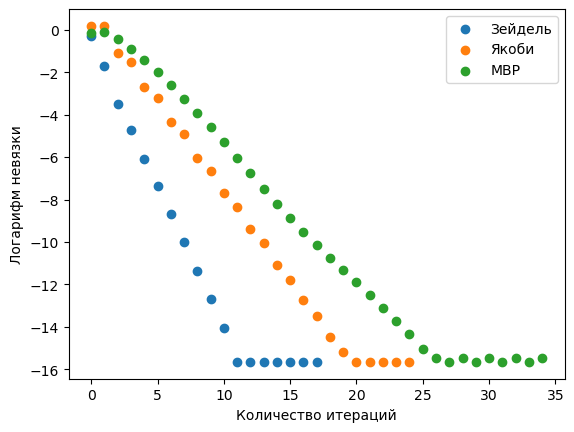

In [28]:
def test(method, n_iter, name):
    A = initialMatrix()
    f = initialFreevec()

    roots, diff = method(n_iter, A, f)
    ref_roots = np.linalg.solve(A, f)

    print(f"Сравнение ({name}):")
    print(norm(roots - ref_roots))
    print(norm(np.matmul(A, roots) - f))
    print(norm(np.matmul(A, ref_roots) - f))

    plt.scatter(range(0, len(diff)), np.log10(diff), label=name)

test(soleZeydel, 18, "Зейдель")
test(soleJacobi, 25, "Якоби")
test(lambda n_iter, matrix, free: soleSOR(n_iter, matrix, free, 1.2), 35, "МВР")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()